In [1]:
import torch
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import transforms, ops
from torchvision.models import vgg19
from ultralytics import YOLO

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2

import os
from tqdm import tqdm
from sklearn.model_selection import KFold


import datasets
# import models

In [2]:
class YoloModel(YOLO):
    def __init__(self, *args, **kwargs):
        super(YoloModel, self).__init__(*args, **kwargs)
    def __str__(self):
        return ""
    def __repr__(self):
        return ""


class roiVGGYolo(torch.nn.Module):
    def __init__(self, numROIs: int, tsfms):
        super(roiVGGYolo, self).__init__()
        self.vgg = vgg19(weights = "DEFAULT")
        self.vggConvFeatures = self.vgg.features[:35]
        self.yolo = YoloModel("yolov8n.pt")
        self.MLP = torch.nn.Sequential(
            torch.nn.Linear(25088, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, numROIs),
        )
        self.tsfms = tsfms
        self.gradients = None

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, img, imgPaths):
        #extract vgg features from image
        convFeatures = self.vggConvFeatures(img)
        hook = convFeatures.register_hook(self.activations_hook)

        #transform the original images such as it's compatible with the YOLO model
        yoloInput = [self.tsfms(Image.open(image)) for image in imgPaths]

        #Make YOLO predictions on images and get bounding box data
        yoloResults = [results.boxes for results in self.yolo.predict(torch.stack(yoloInput), verbose=False)]
        boundingBoxDataAllImages = self.getMappedBoundingBox(yoloResults)
        finalFMRIs = []
        indices = []
        count = 0

        #for each detected bounding box
        for boundingBoxData in boundingBoxDataAllImages:
            #if no bounding boxes, continue
            if len(boundingBoxData) == 0:
                continue

            #pool the features in the regions that overlap with a bounding box. returns a result for each detected object
            objectROIPools = ops.roi_pool(convFeatures, [boundingBoxData], output_size = (7,7))
            fmriPieces = []

            #for the pooled results for each object, predict the partial fmri data
            for objectROIPool in objectROIPools:
                input = torch.flatten(objectROIPool)
                fmriPieces.append(self.MLP(input))

            #sum over all partial fmri data
            totalFMRI = torch.sum(torch.stack(fmriPieces), dim=0)
            finalFMRIs.append(totalFMRI)
            indices.append(count)
            count+=1
        return torch.stack(finalFMRIs), indices 

    #extract bounding box data for each of the yolo results objects
    def getMappedBoundingBox(self, yoloResults):
        mappedBoxes = []
        for result in yoloResults:
            #get normalized top left and bottom right coordinates for the bounding box
            boundingBoxData = result.xyxyn

            #Get interested cells in 7x7 matrix for ROI pooling
            boundingBoxStartX, boundingBoxStartY, boundingBoxEndX, boundingBoxEndY = boundingBoxData[:, 0], boundingBoxData[:, 1], boundingBoxData[:, 2], boundingBoxData[:, 3]
            transformedBoundingBoxStartX, transformedBoundingBoxStartY, transformedBoundingBoxEndX, transformedBoundingBoxEndY = boundingBoxStartX * 7, boundingBoxStartY * 7, boundingBoxEndX * 7, boundingBoxEndY * 7
            startCellX = torch.floor(transformedBoundingBoxStartX)
            startCellY = torch.floor(transformedBoundingBoxStartY)
            endCellX = torch.ceil(transformedBoundingBoxEndX)
            endCellY = torch.ceil(transformedBoundingBoxEndY)
            mappedBoxes.append(torch.hstack((startCellX.reshape(-1,1), startCellY.reshape(-1,1), endCellX.reshape(-1,1), endCellY.reshape(-1,1))))
        return mappedBoxes

    def get_activation_gradient(self):
        return self.gradients

    def get_activations(self, img):
        return self.vggConvFeatures(img)

    #Overwrite functions so that the model isn't printed on server side after each call to train() or eval()
    def __str__(self):
        return ""
    def __repr__(self):
        return ""

In [3]:
parentDir = "C:/Users/josem/Documents/schoolWork/MQP/algonauts2023_transformers#2Leader/algonauts_2023_challenge_data/"
subj = 1
tsfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

yoloTsfms = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])

trainingDataset = datasets.AlgonautsDataset(parentDir, subj,  transform = tsfms)

c:\Users\josem\Documents\schoolWork\MQP\Git\Brain-Scans-MQP\gradCam\datasets.py:69: RuntimeWarning: Mean of empty slice.
  vals = fmriData[:,np.where(challenge_roi)[0]].mean(axis = 1)
c:\Users\josem\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]
[ 0  1  2  3  4  5  6  7  8 11 12 16 17 18 19 20 21 22 24 25 26 27 28 29 30]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]
[ 0  1  2  3  4  5  6  7  8  9 11 12 13 16 17 18 19 20 21 24 25 26 27 28 29 30]


In [4]:
vggYoloModel = roiVGGYolo(25, yoloTsfms).to("cuda")
bestParams = torch.load("./savedModels/5FoldBestModel.pth", map_location="cuda")
layers_to_load = ['MLP.0.weight', 'MLP.0.bias', 'MLP.2.weight', 'MLP.2.bias', 'MLP.4.weight', 'MLP.4.bias']
filtered_state_dict = {key.lstrip("MLP."): value for key, value in bestParams.items() if any(layer in key for layer in layers_to_load)}


In [5]:
vggYoloModel.MLP.load_state_dict(filtered_state_dict)


<All keys matched successfully>

In [6]:
bestModelData = np.load("./resultsData/5FoldBestModelData.npy")
k_folds = 5

# Use StratifiedKFold for balanced class distribution in each fold
skf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

validationIdxs = list(skf.split(np.arange(9841)))[int(bestModelData[0])][1]
validationSubset = Subset(trainingDataset, validationIdxs)

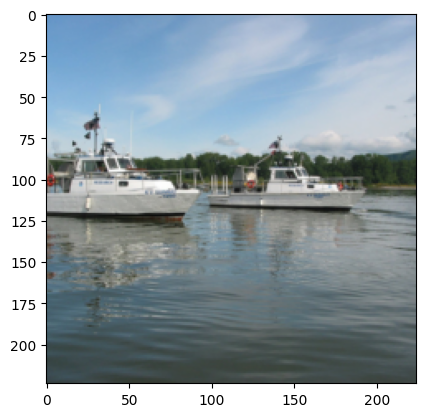

In [168]:
testData = validationSubset.__getitem__(36)
plt.imshow(testData[0].permute(1,2,0))

In [51]:
# testData = validationSubset.__getitem__(7)
# results = vggYoloModel(testData[0][None, :, :, :].to("cuda"), [testData[1]])
# loss =torch.nn.MSELoss()
# loss(results[0], testData[4].to("cuda"))


c:\Users\josem\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([1, 25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1093, device='cuda:0', grad_fn=<MseLossBackward0>)

In [95]:
results[0]

tensor([[-2.3045e-01, -2.5773e-01,  6.7531e-02, -3.2126e-02, -3.6986e-01,  1.0859e-01, -8.3825e-02,  8.4106e-03, -7.7807e-02,  1.0512e-01, -7.1585e-03,  6.2705e-02,  6.2378e-02, -1.7237e-01,  3.1951e-02, -1.3914e-01, -1.1608e-04, -6.7138e-02,  6.2069e-02, -3.1893e-01,  1.4926e-01, -4.9723e-02,  1.0356e-01, -5.6107e-02,
          2.0694e-01]], device='cuda:0', grad_fn=<StackBackward0>)

In [96]:
testData[4]

tensor([-0.2702, -0.4956,  0.0675, -0.1613,  0.1267,  0.0306, -0.1550, -0.0172,  0.1911,  0.1416,  0.2371,  0.1968,  0.1130,  0.0947,  0.1486, -0.0577,  0.1147,  0.0454, -0.2665, -0.0762,  0.1036,  0.0576,  0.0908,  0.0110, -0.0469])

In [ ]:
vggYoloModel.get

In [17]:
count = 0
for thing in trainingDataset.lhROIs:
    print(f"{count} {thing}", end=",  ")
    count += 1

0 V1v,  1 V1d,  2 V2v,  3 V2d,  4 V3v,  5 V3d,  6 hV4,  7 EBA,  8 FBA-1,  9 OFA,  10 FFA-1,  11 OPA,  12 PPA,  13 RSC,  14 OWFA,  15 VWFA-1,  16 VWFA-2,  17 mfs-words,  18 early,  19 midventral,  20 midlateral,  21 midparietal,  22 ventral,  23 lateral,  24 parietal,  

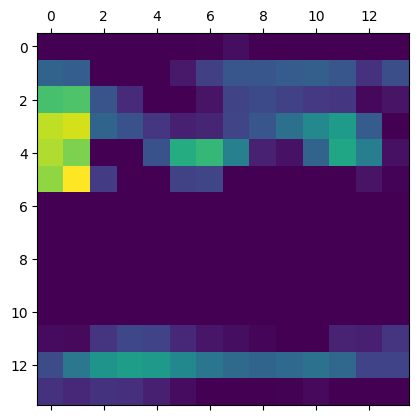

In [169]:
img = testData[0][None, :, :, :].to("cuda")
pred = vggYoloModel(img, [testData[1]])
pred[0][:, 7].backward()
gradients = vggYoloModel.get_activation_gradient()
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vggYoloModel.get_activations(img).detach()


# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze().cpu()
# print(heatmap)

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

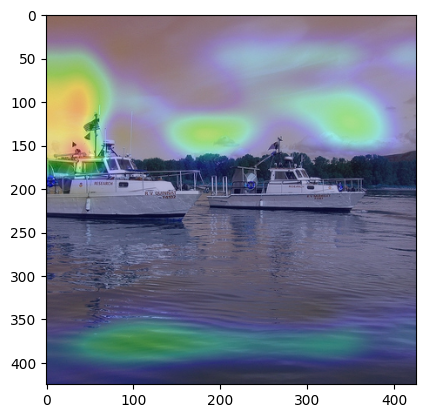

In [170]:
image = cv2.imread(testData[1])
actual = cv2.resize(heatmap.numpy(), (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)

cmap = LinearSegmentedColormap.from_list("Jet", [(0,0,0), (0, 0, 1), (0, 1, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)])

normalized_data = (actual - actual.min()) / (actual.max() - actual.min())

# Apply colormap and convert to integer array
heatmapNew = (cmap(normalized_data) * 255).astype(np.uint8)

# Apply the heatmap to the original image
superimposed_img = cv2.addWeighted(image, 0.7, heatmapNew[:,:,:3], 0.3, 0)
plt.imshow(superimposed_img)